In [1]:
%matplotlib inline
import skimage.io as io
import skimage.measure as measure
import numpy as np
import bqplot as bq

import time
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

from threading import Thread, Lock
from matplotlib import cm
from matplotlib.colors import ListedColormap
from skimage.filters import gaussian

In [2]:
'''################ Reference parameters: concentrations, conductances, potentials and currents ################'''
conc_Na_i_ref = 15   # [Na]i reference (mM)
conc_K_i_ref = 140   # [K]i reference  (mM)
conc_Na_o_ref = 150  # [Na]o reference (mM)
conc_K_o_ref = 5     # [K]o reference  (mM)

G_K_ref = 2500  # K conductance reference (pS)
G_Na_ref = 445  # Na conductance reference (pS)

E_K_ref = -0.06*np.log10(conc_K_i_ref / conc_K_o_ref)  # K equilibrium potential (V)
E_Na_ref = -0.06*np.log10(conc_Na_i_ref / conc_Na_o_ref) # Na equilibrium potential (V)

Vm_init = ( (E_K_ref)*G_K_ref + (E_Na_ref)*G_Na_ref ) \
           / (G_K_ref + G_Na_ref)   # membrane equilibrium potential (V)

I_K_ref = (Vm_init - E_K_ref) * G_K_ref*1e-12 # K current reference (A)
I_Na_ref = (Vm_init - E_Na_ref) * G_Na_ref*1e-12 # Na current reference (A)

'''################ Reference parameters: cell parameters ################'''

cell_radius = 5 # cell radius (um)
cell_vol = (4/3)*np.pi*((cell_radius*1e-6)**3)*1000 # cell volume (L) *slightly different from excel
cell_capacitance = 4*np.pi*(cell_radius**2)*0.01  # cell capacitance (pF)
Rm_ref = 1000/(G_K_ref+G_Na_ref)  # membrane resistance (GOhm)
tau_ref = Rm_ref*cell_capacitance*1e-3  # time constant (s)

'''################ Reference parameters: permeabilities and fluxes ################'''

R = 8.314  # universal gas constant (J*K-1*mol-1)
T = 310.15 # temperature (K)
F = 96485  # Farady cinstant (C*mol-1)
z = 1      # charge number (+1 for K+ and Na+)

alpha = z*F*Vm_init/(R*T)
# K permeability (C*s-1*V-1)
P_K_ref = ( G_K_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_K_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_K_o_ref - conc_K_i_ref*(np.exp(alpha)) ) )
# Na permeability (C*s-1*V-1)
P_Na_ref = ( G_Na_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_Na_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_Na_o_ref - conc_Na_i_ref*(np.exp(alpha)) ) )

J_K_ref = I_K_ref/F    # K flow (mol/s)
J_Na_ref = I_Na_ref/F  # Na flow (mol/s)

'''################ Reference parameter: membrane equilibrium potential ################'''
# membrane equilibrium potential (V) by GHK
Vm_ref = 0.06*np.log10(((P_K_ref*conc_K_o_ref) + (P_Na_ref*conc_Na_o_ref)) \
                         / ((P_K_ref*conc_K_i_ref) + (P_Na_ref*conc_Na_i_ref))) 
Vm = Vm_ref
potential = Vm_ref*1000
Vm_old = Vm_ref*1000
time_step = 0.01

In [3]:
'''################ Language System ################'''
current_language = 'en'  # Default to English

# Language dictionary
translations = {
    'pt': {
        # Widget labels
        'screen_selector': 'Seletor de Tela:',
        'cell_screen': 'Tela da célula',
        'potassium_screen': 'Tela do potássio [K+]',
        'sodium_screen': 'Tela do sódio [Na+]',
        'show_fick': 'Mostrar concentrações por lei de Fick',
        'concentration_instruction': 'Arraste as barras para alterar as concentrações dos íons fora e dentro da célula:',
        'advanced_mode': 'Modo Avançado: abra e feche os canais manualmente!',
        'choose_channels': 'Escolha número de canais abertos de:',
        'open_channel': 'canal aberto',
        'open_channels': 'canais abertos',
        'potential': 'Potencial',
        'delta_potential': 'ΔPotencial',
        'last_second': 'No último segundo:',
        'inside': 'dentro',
        'outside': 'fora',
        'fick_inside': 'dentro Fick',
        'open_k_channel': 'Canal de K+ aberto',
        'closed_k_channel': 'Canal de K+ fechado',
        'open_na_channel': 'Canal de Na+ aberto',
        'closed_na_channel': 'Canal de Na+ fechado',
        # Button labels
        'power_tooltip': 'Liga o simulador',
        'refresh_concentrations': 'Concentrações',
        'refresh_concentrations_tooltip': 'Reinicia concentrações sem alterar número de canais',
        'clear_screen': 'Tela',
        'clear_screen_tooltip': 'Limpa tela e reinicia tempo',
        # Graph labels
        'time_s': 'Tempo (s)',
        'membrane_potential_mv': 'Potencial de Membrana (mV)',
        'concentration_mm': 'Concentração (mM)',
        'potential_label': 'Potencial',
        'k_inside_label': '[K+]dentro',
        'k_outside_label': '[K+]fora',
        'na_inside_label': '[Na+]dentro',
        'na_outside_label': '[Na+]fora',
        'k_inside_fick_label': '[K+]dentro Fick',
        'na_inside_fick_label': '[Na+]dentro Fick'
    },
    'en': {
        # Widget labels
        'screen_selector': 'Screen Selector:',
        'cell_screen': 'Cell screen',
        'potassium_screen': 'Potassium screen [K+]',
        'sodium_screen': 'Sodium screen [Na+]',
        'show_fick': 'Show concentrations by Fick\'s law',
        'concentration_instruction': 'Drag the bars to change ion concentrations inside and outside the cell:',
        'advanced_mode': 'Advanced Mode: manually open and close channels!',
        'choose_channels': 'Choose number of open channels for:',
        'open_channel': 'open channel',
        'open_channels': 'open channels',
        'potential': 'Potential',
        'delta_potential': 'ΔPotential',
        'last_second': 'In the last second:',
        'inside': 'inside',
        'outside': 'outside',
        'fick_inside': 'inside Fick',
        'open_k_channel': 'Open K+ channel',
        'closed_k_channel': 'Closed K+ channel',
        'open_na_channel': 'Open Na+ channel',
        'closed_na_channel': 'Closed Na+ channel',
        # Button labels
        'power_tooltip': 'Turn on simulator',
        'refresh_concentrations': 'Concentrations',
        'refresh_concentrations_tooltip': 'Reset concentrations without changing number of channels',
        'clear_screen': 'Screen',
        'clear_screen_tooltip': 'Clear screen and restart time',
        # Graph labels
        'time_s': 'Time (s)',
        'membrane_potential_mv': 'Membrane Potential (mV)',
        'concentration_mm': 'Concentration (mM)',
        'potential_label': 'Potential',
        'k_inside_label': '[K+]inside',
        'k_outside_label': '[K+]outside',
        'na_inside_label': '[Na+]inside',
        'na_outside_label': '[Na+]outside',
        'k_inside_fick_label': '[K+]inside Fick',
        'na_inside_fick_label': '[Na+]inside Fick'
    }
}

def get_text(key):
    """Get translated text for current language"""
    return translations[current_language].get(key, key)

def update_language():
    """Update all widget text based on current language"""
    # Update main labels
    label_channel_sel.value = f"<b><font color='black'>{get_text('screen_selector')}</b>"
    
    # Update radio button options
    channel_sel.options = [
        get_text('cell_screen'),
        get_text('potassium_screen'), 
        get_text('sodium_screen')
    ]
    
    # Update checkboxes
    show_Fick_check.description = get_text('show_fick')
    label_adv_check.value = get_text('advanced_mode')
    
    # Update instruction labels
    label_concentration.value = get_text('concentration_instruction')
    ch_label.value = get_text('choose_channels')
    label_delta_concentration.value = get_text('last_second')
    
    # Update button descriptions and tooltips
    refresh_button.description = get_text('refresh_concentrations')
    refresh_button.tooltip = get_text('refresh_concentrations_tooltip')
    clear_button.description = get_text('clear_screen')
    clear_button.tooltip = get_text('clear_screen_tooltip')
    power_button.tooltip = get_text('power_tooltip')
    
    # Update ion concentration labels
    label_Na_o.value = f"<b><font color='blue'>[Na<sup>+</sup>]<sub>{get_text('outside')}</sub> &nbsp&nbsp&nbsp(mM):</b>"
    label_Na_i.value = f"<b><font color='43DDCF'>[Na<sup>+</sup>]<sub>{get_text('inside')}</sub> (mM):</b>&nbsp&nbsp&nbsp"
    label_K_o.value = f"<b><font color='purple'>[K<sup>+</sup>]<sub>{get_text('outside')}</sub> &nbsp&nbsp&nbsp(mM):</b>"
    label_K_i.value = f"<b><font color='magenta'>[K<sup>+</sup>]<sub>{get_text('inside')}</sub> (mM):</b>&nbsp&nbsp&nbsp"
    
    # Update graph axis labels
    ax_x1.label = get_text('time_s')
    ax_y1.label = get_text('membrane_potential_mv')
    ax_x2.label = get_text('time_s')
    ax_y2.label = get_text('concentration_mm')
    
    # Update graph line labels
    line1.labels = [get_text('potential_label')]
    line_K_i.labels = [get_text('k_inside_label')]
    line_K_o.labels = [get_text('k_outside_label')]
    line_Na_i.labels = [get_text('na_inside_label')]
    line_Na_o.labels = [get_text('na_outside_label')]
    line_K_i_Fick.labels = [get_text('k_inside_fick_label')]
    line_Na_i_Fick.labels = [get_text('na_inside_fick_label')]
    
    # Update channel slider labels if in advanced mode
    if adv_flag:
        update_channel_labels()
    
    # Update dynamic labels (potential, deltas)
    update_dynamic_labels()

def update_channel_labels():
    """Update channel slider labels based on values"""
    if K_ch_slider.value == 1:
        label_K_ch_slider.value = get_text('open_channel')
    else:
        label_K_ch_slider.value = get_text('open_channels')
        
    if Na_ch_slider.value == 1:
        label_Na_ch_slider.value = get_text('open_channel')
    else:
        label_Na_ch_slider.value = get_text('open_channels')

def update_dynamic_labels():
    """Update labels that change with values"""
    string_potential = f"{get_text('potential')} = {np.around(potential,2)} mV"
    potential_label.value = f"<b><font color='black'>{string_potential}</b>"
    
    string_delta_potential = f"&Delta;{get_text('potential')} = {np.around(delta_potential,2)} mV"
    delta_potential_label.value = f"<b><font color='black'>{string_delta_potential}</b>"
    
    # Update concentration delta labels
    string_delta_K_i = f"&Delta;[K<sup>+</sup>]<sub>{get_text('inside')}</sub> = {np.around(delta_K_i,2)} mM"
    label_delta_K_i.value = f"<font color='magenta'>{string_delta_K_i}"
    
    string_delta_Na_i = f"&Delta;[Na<sup>+</sup>]<sub>{get_text('inside')}</sub> = {np.around(delta_Na_i,2)} mM"
    label_delta_Na_i.value = f"<font color='43DDCF'>{string_delta_Na_i}"
    
    string_delta_K_i_Fick = f"&Delta;[K<sup>+</sup>]<sub>{get_text('fick_inside')}</sub> = {np.around(delta_K_i_Fick,2)} mM"
    label_delta_K_i_Fick.value = f"<font color='pink'>{string_delta_K_i_Fick}"
    
    string_delta_Na_i_Fick = f"&Delta;[Na<sup>+</sup>]<sub>{get_text('fick_inside')}</sub> = {np.around(delta_Na_i_Fick,2)} mM"
    label_delta_Na_i_Fick.value = f"<font color='lightblue'>{string_delta_Na_i_Fick}"

def on_language_change(language):
    """Handle language change"""
    global current_language
    current_language = language
    update_language()

In [4]:
cell_img = io.imread("./data/cell_3ch_patch.tif").astype(float)
cell_mask = io.imread("./data/mask.tif").astype(bool)

In [5]:
def line_array(color,i):
    """Generate a line color array based on the specified color and index."""
    if (color=="cyan") or (color=="c"):
        line = np.array([0/256, (i+1)/256, (i+1)/256, 1])
    elif (color=="magenta") or (color=="m"):
        line = np.array([(i+1)/256, 0/256, (i+1)/256, 1])
    elif (color=="lightblue") or (color=="lb"):
        line = np.array([(i+1)/380, (i+1)/304, (i+1)/286, 1])
    elif (color=="pink") or (color=="p"):
        line = np.array([(i+1)/256, (i+1)/361, (i+1)/341, 1])
    return(line)
def create_fluo_cm(color):
    """Create a colormap with a specified color gradient."""
    grays = cm.get_cmap('gray', 256)
    newcolors = grays(np.linspace(0, 1, 256))
    for i in range(1,newcolors.shape[0]):
        newcolors[i,:] = line_array(color,i)
    newcmp = ListedColormap(newcolors)
    return(newcmp)

In [6]:
cyan_cm = create_fluo_cm("c")
magenta_cm = create_fluo_cm("m")
pink_cm = create_fluo_cm("p")
lightblue_cm = create_fluo_cm("lb")
cm_list = [magenta_cm, cyan_cm, pink_cm, lightblue_cm]

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15820\1612284595.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  grays = cm.get_cmap('gray', 256)


In [7]:
class IonChannel(object):
    """Class to represent an ion channel in the cell membrane."""
    def __init__(self,ion,lin,col,ide):
        self.id = ide
        self.x = int(col)
        self.y = int(lin)
        self.ion = ion
        self.state = 'closed'
    def ch_open(self):
        self.state = 'open'
    def ch_close(self):
        self.state = 'closed'

In [8]:
def create_channels(n=20, ion='K+'): 
    """Create ion channels at random positions on the cell contour."""
    global cell_mask
    # get cell contour
    contours = measure.find_contours(cell_mask.astype(int),0)
    # calculate the step size necessary to divide the contours vector in 30 pieces
    step = len(contours[0])//20
    # calculate the rest that is left of the vector after dividing it in 30 pieces
    rest = len(contours[0])%20
    
    if ion=='K+':
        # takes the coordinates of each step
        coords = contours[0][::step]
        coords = coords[:-1]
    else:
        # takes the coordinates of each step, but starting at half step
        coords = contours[0][step//2::step] 
    ch_list = []
    coords = coords[np.random.choice(20, n, replace=False)]
    for counter,value in enumerate(coords):
        ch_list.append(IonChannel(ion,value[0],value[1],counter))
    return(ch_list)

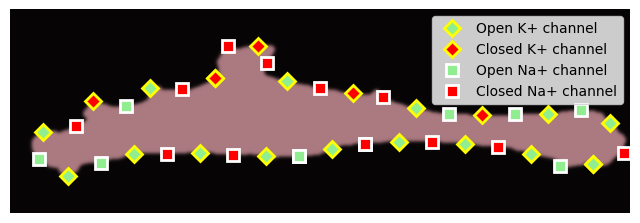

In [9]:
'''################ Callback functions ################'''
def thread_f():
    """Thread function to update simulation parameters continuously"""
    global t, potential_list, potential, K_i, K_o, Na_i, Na_o, line1, line_K_i, line_K_o, line_Na_i, line_Na_o, x_sc1, x_sc2
    global K_i_list, K_o_list, Na_i_list, Na_o_list, t_clear, n_K, n_Na, Na_i_Fick, K_i_Fick, line_K_i_Fick, line_Na_i_Fick
    global K_i_Fick_list, Na_i_Fick_list, clear_flag, channel_sel, power_status, adv_flag
    global show_Fick
    x = 0
    
    # Initialize variables when thread starts
    t_last_reset = 0
    t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
    x_sc1.min = int(x)
    x_sc1.max = int(x+t_clear)
    x_sc2.min = int(x)
    x_sc2.max = int(x+t_clear)
    
    # Thread runs only while power is on
    while power_status:
        t.append(x)
        x += 0.01
        x = np.around(x,2)

        if adv_flag==True:
            update_params(n_K,n_Na,x)
            K_i_Fick_list.append(K_i_Fick)
            Na_i_Fick_list.append(Na_i_Fick)
            line_K_i_Fick.x = t
            line_K_i_Fick.y = K_i_Fick_list
            line_Na_i_Fick.x = t
            line_Na_i_Fick.y = Na_i_Fick_list
            if (x*100)%50==0:
                update_screen(channel_sel.index)
        else:
            K_i_Fick_list.append(K_i)
            Na_i_Fick_list.append(Na_i)

        potential_list.append(potential)
        K_i_list.append(K_i)
        K_o_list.append(K_o)
        Na_i_list.append(Na_i)
        Na_o_list.append(Na_o)
        
        line1.x = t
        line1.y = potential_list
        line_K_i.x = t
        line_K_i.y = K_i_list
        line_K_o.x = t
        line_K_o.y = K_o_list
        line_Na_i.x = t
        line_Na_i.y = Na_i_list
        line_Na_o.x = t
        line_Na_o.y = Na_o_list

        if x%t_clear==0:
            t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
            x_sc1.min = int(x)
            x_sc1.max = int(x+t_clear)
            x_sc2.min = int(x)
            x_sc2.max = int(x+t_clear)
        if clear_flag==True:
            x = 0
            t_last_reset = 0
            t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list = [], [], [], [], [], [], [], []
            x_sc1.min = int(x)
            x_sc1.max = int(x+t_clear)
            x_sc2.min = int(x)
            x_sc2.max = int(x+t_clear)
            clear_flag = False
        
        time.sleep(0.1)

def on_power(v):
    """Toggle power status and start/stop the simulation thread."""
    global power_status, th
    if power_status==True:
        power_button.button_style = 'danger'
        enable_controls(False)
        power_status = False
        # Thread will stop naturally when power_status becomes False
    else:
        power_status = True
        # Create a new thread each time power is turned on
        th = Thread(target=thread_f, daemon=True)
        th.start()
        power_button.button_style = 'success'
        enable_controls(True)
        

def enable_controls(flag):
    """Enable or disable controls based on the power status."""
    if flag==True:
        channel_sel.disabled = False
        K_i_slider.disabled = False
        K_o_slider.disabled = False
        Na_i_slider.disabled = False
        Na_o_slider.disabled = False
        K_ch_slider.disabled = False
        Na_ch_slider.disabled = False
        adv_check.disabled = False
        refresh_button.disabled = False
        clear_button.disabled = False
    else:
        channel_sel.disabled = True
        K_i_slider.disabled = True
        K_o_slider.disabled = True
        Na_i_slider.disabled = True
        Na_o_slider.disabled = True
        K_ch_slider.disabled = True
        Na_ch_slider.disabled = True
        adv_check.disabled = True
        refresh_button.disabled = True
        clear_button.disabled = True
    return
        
def on_show_Fick(v):
    """Toggle the visibility of Fick's law lines and labels in the plot."""
    global show_Fick
    show_Fick = v['new']
    
    # Update the figure marks based on show_Fick state
    if show_Fick == True:
        # Add Fick lines to the plot
        fig2.marks = [line_K_i, line_K_o, line_Na_i, line_Na_o, line_K_i_Fick, line_Na_i_Fick]
        # Show Fick labels
        label_delta_K_i_Fick.layout.visibility = 'visible'
        label_delta_Na_i_Fick.layout.visibility = 'visible'
    else:
        # Remove Fick lines from the plot
        fig2.marks = [line_K_i, line_K_o, line_Na_i, line_Na_o]
        # Hide Fick labels
        label_delta_K_i_Fick.layout.visibility = 'hidden'
        label_delta_Na_i_Fick.layout.visibility = 'hidden'
    
    # Update the screen to reflect colormap changes if needed
    update_screen(channel_sel.index)
    
def on_refresh_button(v):
    """Reset concentrations and update the screen."""
    global refresh_flag
    refresh_flag = True
    reset()
    refresh_flag = False
    
def on_clear(v):
    """Clear the screen and reset the simulation."""
    global clear_flag
    clear_flag = True


def on_channel_sel(v):
    """Update the screen based on the selected channel."""
    value = v['owner'].index
    update_screen(value)

def update_screen(ch_index):
    """Update the cell image based on the selected channel index and current concentrations."""
    global cell_img, cell_mask, K_list, Na_list, Na_i, Na_o, K_i, K_o, show_Fick, K_i_Fick, Na_i_Fick
    global lock, adv_check, cm_list, out, channel_sel

    with lock:
        if ch_index == 1:
            value_out = K_o
            value_in = K_i if not show_Fick else K_i_Fick
        elif ch_index == 2:
            value_out = Na_o
            value_in = Na_i if not show_Fick else Na_i_Fick

        if ch_index != 0:
            cell_img[:, :, ch_index][cell_mask] = value_in
            cell_img[:, :, ch_index][np.invert(cell_mask)] = value_out
            cell_img[:, :, ch_index] = gaussian(cell_img[:, :, ch_index], sigma=2)

        out.clear_output(wait=True)
        with out:
            fig, ax = plt.subplots(figsize=(8, 5))
            if ch_index == 0:
                im = ax.imshow(cell_img[:, :, 0], cmap='gray')
                ax.axis('off')
            else:
                K_open_count = 0
                K_closed_count = 0
                Na_open_count = 0
                Na_closed_count = 0
                cm_index = ch_index
                if show_Fick:
                    cm_index += 2
                im = ax.imshow(cell_img[:, :, ch_index], cmap=cm_list[cm_index - 1], vmin=0, vmax=200)
                ax.axis('off')
                if adv_check.value:
                    for ch in K_list:
                        color = 'lightgreen' if ch.state == 'open' else 'r'
                        if ch.state == 'open' and K_open_count == 0:
                            marker_K_open, = ax.plot(
                                ch.x, ch.y, marker='D', color=color, markersize=8, mew=2, mec='yellow', ls=''
                            )
                            marker_K_open.set_label(get_text('open_k_channel'))
                            K_open_count += 1
                        if ch.state == 'closed' and K_closed_count == 0:
                            marker_K_closed, = ax.plot(
                                ch.x, ch.y, marker='D', color=color, markersize=8, mew=2, mec='yellow', ls=''
                            )
                            marker_K_closed.set_label(get_text('closed_k_channel'))
                            K_closed_count += 1
                        ax.plot(ch.x, ch.y, marker='D', color=color, ms=8, mew=2, mec='yellow')
                    for ch in Na_list:
                        color = 'lightgreen' if ch.state == 'open' else 'r'
                        if ch.state == 'open' and Na_open_count == 0:
                            marker_Na_open, = ax.plot(
                                ch.x, ch.y, marker='s', color=color, markersize=8, mew=2, mec='white', ls=''
                            )
                            marker_Na_open.set_label(get_text('open_na_channel'))
                            Na_open_count += 1
                        if ch.state == 'closed' and Na_closed_count == 0:
                            marker_Na_closed, = ax.plot(
                                ch.x, ch.y, marker='s', color=color, markersize=8, mew=2, mec='white', ls=''
                            )
                            marker_Na_closed.set_label(get_text('closed_na_channel'))
                            Na_closed_count += 1
                        ax.plot(ch.x, ch.y, marker='s', color=color, ms=8, mew=2, mec='white')
                    ax.legend()
            plt.show()
            plt.close(fig)


def reset():
    """Reset the simulation parameters to their initial values."""
    global cell_img, cell_mask, t, potential_list, K_i_list, K_o_list, Na_i_list, Na_o_list, K_i_Fick_list, Na_i_Fick_list
    global Na_o, Na_i, K_o, K_i, potential, K_i_Fick, Na_i_Fick, delta_potential, n_K, n_Na, P_K, P_Na, P_K_ref, P_Na_ref
    global clear_flag, Vm_ref, channel_sel, t_last_reset, delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick
    global K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old, show_Fick, adv_flag
    K_i, K_o, Na_i, Na_o = 140, 5, 15, 150
    K_i_Fick, Na_i_Fick = 140, 15
    K_i_slider.value, K_o_slider.value, Na_i_slider.value, Na_o_slider.value = 140, 5, 15, 150
    K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old = 140, 140, 15, 15
    potential = Vm_ref*1000
    delta_potential = 0
    delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick = 0, 0, 0, 0
    update_dynamic_labels()

    if show_Fick==True:
        label_delta_Na_i_Fick.layout.visibility = 'visible'
        label_delta_K_i_Fick.layout.visibility = 'visible'
    else:
        label_delta_Na_i_Fick.layout.visibility = 'hidden'
        label_delta_K_i_Fick.layout.visibility = 'hidden'

    if len(t)>0:
        t_last_reset = t[-1]
    else:
        t_last_reset = 0

    if refresh_flag == False:
        adv_check.value = False
        adv_flag = False
        show_Fick = False
        show_Fick_check.value = False
        vbox_num_ch.children = []
        hbox_num_ch_and_button.children = []
        hbox_num_ch_and_button.layout.visibility='hidden'
        vbox_num_ch.layout.visibility = 'hidden'
        refresh_button.layout.visibility = 'hidden'
        label_concentration_hbox.layout.visibility = 'hidden'
        show_Fick_check.layout.visibility = 'hidden'
        P_K, P_Na = P_K_ref, P_Na_ref
        n_K, n_Na = 20, 1
        K_ch_slider.value, Na_ch_slider.value = 20, 1
    
        Na_o_slider.disabled = False
        Na_i_slider.disabled = False
        K_o_slider.disabled = False
        K_i_slider.disabled = False
        fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o]
        channel_sel.index = 0

    update_screen(channel_sel.index)
    

def on_concentration_slider(v):
    '''Function that updates images when concentration bars are changed'''
    global cell_img, cell_mask, potential,delta_potential
    global Na_o, Na_i, K_o, K_i, cell_img_hm, Vm_old, Vm_new, tau_ref, Vm

    value = v['new']
    if value==0:
        value = 0.1
    # if changed bar is K+ i
    if v['owner'].tooltip.startswith('[K+]i'):
        channel_sel.index = 1
        K_i = value
    # if changed bar is K+ o
    elif v['owner'].tooltip.startswith('[K+]o'):
        channel_sel.index = 1
        K_o = value
    # if changed bar is Na+ i
    elif v['owner'].tooltip.startswith('[Na+]i'):
        channel_sel.index = 2
        Na_i = value
    # if changed bar is Na+ i
    elif v['owner'].tooltip.startswith('[Na+]o'):
        channel_sel.index = 2
        Na_o = value
    P_K = P_K_ref
    P_Na = P_Na_ref
    # updates potential
    Vm_old = Vm
    Vm_new = 0.06*np.log10(((P_K*K_o) + (P_Na*Na_o)) \
                     / ((P_K*K_i) + (P_Na*Na_i)))
    A = Vm_old - Vm_new
    # new membrane potential function at time t (mV)    
    Vm = A*np.exp(-time_step/tau_ref) + Vm_new
    delta_potential = (Vm*1000) - potential
    potential = Vm*1000
    string_potential = 'Potencial = ' + str(np.around(potential,2)) + ' mV'
    potential_label.value = f"<b><font color='black'>{string_potential}</b>"
    string_delta_potential = '&Delta;Potencial = ' + str(np.around(delta_potential,2)) + ' mV'
    delta_potential_label.value = f"<b><font color='black'>{string_delta_potential}</b>"
    update_screen(channel_sel.index)

def on_adv_check(v):
    """Handle the toggle of advanced mode for channel selection."""
    global Na_o_vector, Na_i_vector, K_o_vector, K_i_vector, potential, n_Na, n_K, adv_flag, show_Fick
    
    adv_flag = v['new']
    if adv_flag==True:
        vbox_num_ch.children = [ch_label, hbox_K_ch_slider, hbox_Na_ch_slider]
        hbox_num_ch_and_button.children = [vbox_num_ch,refresh_button]
        update_channel_labels() 
        n_Na, n_K = Na_ch_slider.value, K_ch_slider.value
        hbox_num_ch_and_button.layout.visibility='visible' 
        vbox_num_ch.layout.visibility = 'visible'
        refresh_button.layout.visibility = 'visible'
        label_concentration_hbox.layout.visibility = 'visible'
        show_Fick_check.layout.visibility = 'visible'
        Na_o_slider.value = 150
        Na_i_slider.value = 15
        K_o_slider.value = 5
        K_i_slider.value = 140
        Na_o_slider.disabled = True
        Na_i_slider.disabled = True
        K_o_slider.disabled = True
        K_i_slider.disabled = True
        channel_sel.index = 1
        if show_Fick==True:
            fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o,line_K_i_Fick, line_Na_i_Fick]
        else:
            fig2.marks=[line_K_i,line_K_o,line_Na_i,line_Na_o]
        
        on_channel_slider(0)
    else:
        reset()

def update_params(K_channels, Na_channels,x):
    """Update the simulation parameters based on the number of open channels."""
    global R, T, F, z, cell_vol, conc_K_o_ref, conc_Na_o_ref, P_K_ref, \
                P_Na_ref, cell_capacitance, Na_i, K_i, potential, K_i_Fick, Na_i_Fick, t, Vm, potential_label
    global delta_potential_label, t_last_reset, channel_change_flag, delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick
    global label_delta_K_i, label_delta_K_i_Fick, label_delta_Na_i, label_delta_Na_i_Fick
    global K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old
    
    # new potential values
    E_K = -0.06*np.log10(K_i/conc_K_o_ref)
    E_Na = -0.06*np.log10(Na_i/conc_Na_o_ref)
    
    P_K = P_K_ref*(K_channels/20) 
    P_Na = P_Na_ref*Na_channels    
    Vm = potential/1000
    # new conducatances (S)
    alpha = z*F*Vm/(R*T)
    G_K = ((z*F)**2)*P_K*Vm*( conc_K_o_ref - K_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_K) )
    G_Na = ((z*F)**2)*P_Na*Vm*( conc_Na_o_ref - Na_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_Na) )
    
    tau = cell_capacitance*1e-12 / (G_K + G_Na) # in (s)

    # new currents (A)
    I_K = G_K*(Vm - E_K) 
    I_Na = G_Na*(Vm - E_Na) 
    # new flows (mols/s)
    J_K = I_K/F    
    J_Na = I_Na/F  
    # new concentrations (mM)
    K_i -= 1e3*J_K*time_step/cell_vol
    Na_i -= 1e3*J_Na*time_step/cell_vol

    # V(t) = A*exp(-t/tau) + D
    # D = Vnew
    # A = Vold - Vnew
    # V(t) = (Vold - Vnew)*exp(-t/tau) + Vnew
    Vm_old = Vm
    Vm_new = 0.06*np.log10(((P_K*conc_K_o_ref) + (P_Na*conc_Na_o_ref)) \
                     / ((P_K*K_i) + (P_Na*Na_i)))
    A = Vm_old - Vm_new
    # new membrane potential function at time t (mV)    
    Vm = A*np.exp(-0.01/tau) + Vm_new
    delta_potential = (Vm*1000) - potential
    potential = Vm*1000
    if channel_change_flag==True:
        update_dynamic_labels()

        channel_change_flag = False
    ### Fick's law ###
    J_K_Fick = P_K*(conc_K_o_ref - K_i_Fick)
    J_Na_Fick = P_Na*(conc_Na_o_ref - Na_i_Fick)
    # new concentrations (mM)
    if len(t)>0:
        K_i_Fick += 1e3*J_K_Fick*(time_step)/cell_vol
        Na_i_Fick += 1e3*J_Na_Fick*(time_step)/cell_vol
        
    if (x-t_last_reset)%1==0:
        delta_K_i = K_i - K_i_old
        K_i_old = K_i
        delta_K_i_Fick = K_i_Fick -  K_i_Fick_old
        K_i_Fick_old = K_i_Fick
        delta_Na_i = Na_i - Na_i_old
        Na_i_old = Na_i
        delta_Na_i_Fick = Na_i_Fick -  Na_i_Fick_old
        Na_i_Fick_old = Na_i_Fick
        update_dynamic_labels()
    
def on_channel_slider(v):
    """Handle changes in the channel slider values."""
    global K_list, Na_list
    global cell_img, cell_mask, Na_i, K_i, n_K, n_Na, channel_change_flag
    if v==0:
        K_ch_slider.value = 20
        label_K_ch_slider.value = get_text('open_channels')  # Use translation
        Na_ch_slider.value = 1
        label_Na_ch_slider.value = get_text('open_channel')   # Use translation
        n_K, n_Na = 20, 1
    else:
        channel_change_flag = True
        value = v['new']
        if v['owner'].description.startswith('K+'):
            channel_sel.index = 1
            n_K = value
            update_channel_labels()  # Use the translation function
            for i in range(value):
                K_list[i].ch_open()
            for i in range(value,len(K_list)):
                K_list[i].ch_close()
        elif v['owner'].description.startswith('Na+'):
            channel_sel.index = 2
            n_Na = value
            update_channel_labels()  # Use the translation function
            for i in range(value):
                Na_list[i].ch_open()
            for i in range(value,len(Na_list)):
                Na_list[i].ch_close()

    update_screen(channel_sel.index)

'''################ Widgets construction ################'''
power_button = widgets.Button(
    description='',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip=get_text('power_tooltip'),
    icon='power-off', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='40px',border='2px solid black')
)
# Language selector buttons (add after power_button creation)
pt_flag_button = widgets.Button(
    description='🇧🇷',
    disabled=False,
    button_style='success' if current_language == 'pt' else '',
    tooltip='Português',
    layout=widgets.Layout(width='40px', height='30px')
)

en_flag_button = widgets.Button(
    description='🇺🇸',
    disabled=False,
    button_style='success' if current_language == 'en' else '',
    tooltip='English',
    layout=widgets.Layout(width='40px', height='30px')
)

def on_pt_flag(b):
    """Handle the Portuguese flag button click event."""
    global current_language
    if current_language != 'pt':
        on_language_change('pt')
        pt_flag_button.button_style = 'success'
        en_flag_button.button_style = ''

def on_en_flag(b):
    """Handle the English flag button click event."""
    global current_language
    if current_language != 'en':
        on_language_change('en')
        en_flag_button.button_style = 'success'
        pt_flag_button.button_style = ''

# Connect flag button events
pt_flag_button.on_click(on_pt_flag)
en_flag_button.on_click(on_en_flag)

# Create language selector box
language_box = widgets.HBox([pt_flag_button, en_flag_button], 
                           layout=widgets.Layout(margin='0px 10px 0px 0px'))
# Title widget for radiobox for channel selection
label_channel_sel = widgets.HTML(value = f"<b><font color='black'>{get_text('screen_selector')}</b>")
# Widget of radiobox for channel selection
channel_sel = widgets.RadioButtons(
    options=[get_text('cell_screen'), get_text('potassium_screen'), get_text('sodium_screen')],
    description='',
    disabled=True 
)

show_Fick_check = widgets.Checkbox(
    value=False,
    description=get_text('show_fick'),
    disabled=False,
    indent=False,
    layout=widgets.Layout(visibility='hidden',margin = '40px 0px 0px 0px')
)

channel_sel_hbox = widgets.HBox([power_button, label_channel_sel, channel_sel, show_Fick_check, language_box])

# widget of output images
out = widgets.Output(layout={'border': '1px solid black'})
# widget label for concentration sliders
label_concentration = widgets.Label(get_text('concentration_instruction'))

label_Na_o = widgets.HTML(
    value = f"<b><font color='blue'>[Na<sup>+</sup>]<sub>{get_text('outside')}</sub> &nbsp&nbsp&nbsp(mM):</b>"
)
label_Na_o.layout.width = '112px'
# widget of Na+ o slider
Na_o_slider = widgets.IntSlider(
    value=150,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip = '[Na+]o (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_Na_o_slider = widgets.HBox([label_Na_o,Na_o_slider])

label_Na_i = widgets.HTML(value = f"<b><font color='43DDCF'>'[Na<sup>+</sup>]<sub>{get_text('inside')}</sub> (mM):'</b>&nbsp&nbsp&nbsp")
# widget of Na+ i slider
Na_i_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[Na+]i (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_Na_i_slider = widgets.HBox([label_Na_i,Na_i_slider])

label_K_o = widgets.HTML(value = f"<b><font color='purple'>'[K<sup>+</sup>]<sub>{get_text('outside')}</sub> &nbsp&nbsp&nbsp(mM):'</b>")
label_K_o.layout.width = '105px'
# widget of K+ o slider
K_o_slider = widgets.IntSlider(
    value=5,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[K+]o (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_K_o_slider = widgets.HBox([label_K_o,K_o_slider])

label_K_i = widgets.HTML(value = f"<b><font color='magenta'>'[K<sup>+</sup>]<sub>{get_text('inside')}</sub> (mM):'</b>&nbsp&nbsp&nbsp")
# widget of K+ o slider
K_i_slider = widgets.IntSlider(
    value=140,
    min=0,
    max=200,
    step=1,
    description='',
    tooltip='[K+]i (mM)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
hbox_K_i_slider = widgets.HBox([label_K_i,K_i_slider])



adv_check = widgets.Checkbox(
    value=False,
    description='',
    disabled=True,
    indent=False
)

clear_button = widgets.Button(
    description=get_text('clear_screen'),
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip=get_text('clear_screen_tooltip'),
    icon='refresh', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(visibility='visible', align_self='flex-end')
)

adv_check.layout.width='20px'
label_adv_check = widgets.Label(get_text('advanced_mode'))
adv_box = widgets.HBox([adv_check,label_adv_check])
ch_label = widgets.Label(
    value=get_text('choose_channels'),
)

Na_ch_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='Na+ (■)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
label_Na_ch_slider = widgets.Label(
    value=get_text('open_channels')
)
hbox_Na_ch_slider = widgets.HBox([Na_ch_slider,label_Na_ch_slider])

K_ch_slider = widgets.IntSlider(
    value=20,
    min=1,
    max=20,
    step=1,
    description='K+ (♦)',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(align_self='flex-start')
)
label_K_ch_slider = widgets.Label(
    value=get_text('open_channels')
)
hbox_K_ch_slider = widgets.HBox([K_ch_slider,label_K_ch_slider])

n_Na, n_K = Na_ch_slider.value, K_ch_slider.value

K_list = create_channels(n=20,ion='K+')
for i in range(K_ch_slider.value):
    K_list[i].ch_open()
Na_list = create_channels(n=20,ion='Na+')
for i in range(Na_ch_slider.value):
    Na_list[i].ch_open()

K_i, K_o, Na_i, Na_o = 140, 5, 15, 150
K_i_Fick, Na_i_Fick = K_i, Na_i
K_i_old, K_i_Fick_old, Na_i_old, Na_i_Fick_old = 140, 140, 15, 15
power_status = False
clear_flag = False
refresh_flag = False
channel_change_flag = False
adv_flag = False
show_Fick = False
t_last_reset = 0

th = None

refresh_button = widgets.Button(
    description=get_text('refresh_concentrations'),
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip= get_text('refresh_concentrations_tooltip'),
    icon='refresh', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(visibility='hidden')
)

# Block of widgets containing Na+ sliders
vbox_conc_Na = widgets.VBox([hbox_Na_o_slider,hbox_Na_i_slider],layout = widgets.Layout(justify_content='center'))
# Block of widgets containing K+ sliders
vbox_conc_K = widgets.VBox([hbox_K_o_slider,hbox_K_i_slider],layout = widgets.Layout(justify_content='center'))
# Block of widgets containing num K+ channel slider
vbox_num_ch = widgets.VBox(layout = widgets.Layout(justify_content='center'))
vbox_num_ch.layout.visibility = 'hidden'
hbox_num_ch_and_button = widgets.HBox(layout = widgets.Layout(justify_content='space-between',align_items='center'))
hbox_num_ch_and_button.visibility = 'hidden'


string_potential = f"{get_text('potential')} = {np.around(potential,2)} mV"
potential_label = widgets.HTML(value = f"<b><font color='black'>{string_potential}</b>")
delta_potential = 0
string_delta_potential = f"&Delta;{get_text('potential')} = {np.around(delta_potential,2)} mV"
delta_potential_label = widgets.HTML(value = f"<b><font color='black'>{string_delta_potential}</b>")
delta_potential_label.layout.border = '1px dashed black'


delta_K_i, delta_K_i_Fick, delta_Na_i, delta_Na_i_Fick = 0.0, 0.0, 0.0, 0.0

label_delta_concentration = widgets.Label(get_text('last_second'))
string_delta_K_i = f"&Delta;[K<sup>+</sup>]<sub>{get_text('inside')}</sub> = {np.around(delta_K_i,2)} mM"
label_delta_K_i = widgets.HTML(value = f"<font color='magenta'>{string_delta_K_i}")
label_delta_K_i.layout.border = '1px dashed black'
string_delta_Na_i = f"&Delta;[Na<sup>+</sup>]<sub>{get_text('inside')}</sub> = {np.around(delta_Na_i,2)} mM"
label_delta_Na_i = widgets.HTML(value = f"<font color='43DDCF'>{string_delta_Na_i}")
label_delta_Na_i.layout.border = '1px dashed black'
string_delta_K_i_Fick = f"&Delta;[K<sup>+</sup>]<sub>{get_text('fick_inside')}</sub> = {np.around(delta_K_i_Fick,2)} mM"
label_delta_K_i_Fick = widgets.HTML(value = f"<font color='pink'>{string_delta_K_i_Fick}")
label_delta_K_i_Fick.layout.border = '1px dashed black'
string_delta_Na_i_Fick = f"&Delta;[Na<sup>+</sup>]<sub>{get_text('fick_inside')}</sub> = {np.around(delta_Na_i_Fick,2)} mM"
label_delta_Na_i_Fick = widgets.HTML(value = f"<font color='lightblue'>{string_delta_Na_i_Fick}")
label_delta_Na_i_Fick.layout.border = '1px dashed black'
if show_Fick==True:
    label_delta_Na_i_Fick.layout.visibility = 'visible'
    label_delta_K_i_Fick.layout.visibility = 'visible'
else:
    label_delta_Na_i_Fick.layout.visibility = 'hidden'
    label_delta_K_i_Fick.layout.visibility = 'hidden'

label_delta_dentro_vbox = widgets.VBox([label_delta_K_i,label_delta_Na_i])
label_delta_dentro_Fick_vbox = widgets.VBox([label_delta_K_i_Fick,label_delta_Na_i_Fick])
label_concentration_hbox = widgets.HBox([label_delta_concentration,label_delta_dentro_vbox,label_delta_dentro_Fick_vbox],
                                       layout=widgets.Layout(margin='0px 80px 0px 0px'))
label_concentration_hbox.layout.visibility = 'hidden'

# # Show graphics on first time
'''################ First graph properties (fig1) ################'''
x_sc1 = bq.LinearScale()
y_sc1 = bq.LinearScale()
t_clear = 5
x_sc1.min = 0
x_sc1.max = t_clear
y_sc1.min = -210
y_sc1.max = 210

ax_x1 = bq.Axis(label=get_text('time_s'), scale=x_sc1, grid_lines='solid', tick_format='0.1f', 
                tick_style = {'font-size': 14})
ax_y1 = bq.Axis(label=get_text('membrane_potential_mv'), scale=y_sc1, orientation='vertical', tick_format='0.1f',
                 tick_style = {'font-size': 14},label_offset = '6ex')

t, potential_list = [], []
line1 = bq.Lines(x=t, y=potential_list, scales={'x': x_sc1, 'y': y_sc1} , colors=['black'],display_legend = True, labels=[get_text('potential')],stroke_width = 2.0)

fig1 = bq.Figure(axes=[ax_x1, ax_y1], marks=[line1], fig_margin={'top':0, 'bottom':40, 'left':80, 'right':0})
fig1.legend_style = {'stroke-width': 0}
fig1.layout = {'height': '300px','width': '400px'}
'''################ Second graph properties (fig2) ################'''
x_sc2 = bq.LinearScale()
y_sc2 = bq.LinearScale()

x_sc2.min = 0
x_sc2.max = t_clear
y_sc2.min = -10
y_sc2.max = 310

ax_x2 = bq.Axis(label=get_text('time_s'), scale=x_sc2, grid_lines='solid', tick_format='0.1f', 
                tick_style = {'font-size': 14})
ax_y2 = bq.Axis(label=get_text('concentration_mm'), scale=y_sc2, orientation='vertical', tick_format='d',
                 tick_style = {'font-size': 14},label_offset = '6ex')

K_i_list, K_o_list, Na_i_list, Na_o_list, Na_i_Fick_list, K_i_Fick_list = [], [], [], [], [], []
line_K_i = bq.Lines(x=t, y=K_i_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['magenta'],display_legend = True, labels=[get_text('k_inside_label')],stroke_width = 2.0)
line_K_o = bq.Lines(x=t, y=K_o_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['purple'],display_legend = True, labels=[get_text('k_outside_label')],stroke_width = 2.0)
line_Na_i = bq.Lines(x=t, y=Na_i_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['#43DDCF'],display_legend = True, labels=[get_text('na_inside_label')],stroke_width = 2.0)
line_Na_o = bq.Lines(x=t, y=Na_o_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['blue'],display_legend = True, labels=[get_text('na_outside_label')],stroke_width = 2.0)
line_K_i_Fick = bq.Lines(x=t, y=K_i_Fick_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['pink'],display_legend = True, labels=[get_text('k_inside_fick_label')],stroke_width = 2.0)
line_Na_i_Fick = bq.Lines(x=t, y=Na_i_Fick_list, scales={'x': x_sc2, 'y': y_sc2} , colors=['lightblue'],display_legend = True, labels=[get_text('na_inside_fick_label')],stroke_width = 2.0)

fig2 = bq.Figure(axes=[ax_x2, ax_y2], marks=[line_K_i,line_K_o,line_Na_i,line_Na_o], fig_margin={'top':0, 'bottom':40, 'left':80, 'right':0})
fig2.layout = {'height': '300px','width': '400px'}
# legend = legendWidget(fig2.marks)     
fig2.legend_location = 'top'
fig2.legend_style = {'stroke-width': 0}


'''################### Block of widgets containing all graphics and labels ################'''
label_potential_vbox = widgets.VBox([potential_label,delta_potential_label])
label_deltas_box = widgets.HBox([label_potential_vbox,clear_button,label_concentration_hbox],layout=widgets.Layout(justify_content='space-between'))
hbox_graphics = widgets.HBox([fig1,fig2], align_contents='stretch',align_items='stretch',justify_content='center')
vbox_graphics_and_label = widgets.VBox([label_deltas_box,hbox_graphics])
vbox_graphics_and_label.layout.border = '1px solid black'

# Block of widgets containing all concentration sliders
hbox_ions = widgets.HBox([vbox_conc_K,vbox_conc_Na],justify_content='center',align_content='center')
# Block of widgets containing channel selection and output images
vbox_fig = widgets.VBox([channel_sel_hbox,out,label_concentration,hbox_ions,adv_box,hbox_num_ch_and_button,vbox_graphics_and_label], justify_content='center')

with out:
    # Clear any existing output first
    out.clear_output(wait=True)
    
    plt.ioff()  # Turn off interactive mode for matplotlib
    # create figure and axes
    fig, ax = plt.subplots(figsize=(8,5))
    # show cell image on axes
    im = ax.imshow(cell_img[:,:,0],cmap='gray')
    ax.axis('off')
    
    # Use plt.show() instead of display(fig) for consistency
    plt.show()
    plt.close(fig)  # Close the figure to prevent memory leaks
    plt.ion()  # Turn on interactive mode for matplotlib

out.layout.display = 'flex'
out.layout.align_items = 'center'
out.layout.justify_items = 'center'
out.layout.align_self = 'center'

# Link changes in Radiobox widget (channel selection) to screen update function
channel_sel.observe(on_channel_sel,names='value')
# Link changes in slider widgets (ion concentrations) to concentration function
K_i_slider.observe(on_concentration_slider, names='value')
K_o_slider.observe(on_concentration_slider, names='value')
Na_i_slider.observe(on_concentration_slider, names='value')
Na_o_slider.observe(on_concentration_slider, names='value')
adv_check.observe(on_adv_check, names='value')
K_ch_slider.observe(on_channel_slider, names='value')
Na_ch_slider.observe(on_channel_slider, names='value')
refresh_button.on_click(on_refresh_button)
power_button.on_click(on_power)
clear_button.on_click(on_clear)
show_Fick_check.observe(on_show_Fick, names='value')

lock = Lock()

vbox_fig_layout = widgets.Layout()
vbox_fig_layout.margin = '20px'
vbox_fig.layout = vbox_fig_layout

main_box = widgets.VBox([vbox_fig])
main_box.layout.align_items = 'center'
main_box.layout.border = '1px solid black'
main_box.box_style = ''

# Display main Block of widgets
main_box

In [10]:
# reset: volta para as codições iniciais, inclusive num de canais (não limpa gráficos)
# refresh: volta para as codições iniciais, exceto num de canais (não limpa gráficos)
# restart: volta para as condições iniciais, inclusive num de canais E limpa gráficos (zera tempo)

# reset usado ao sair do modo avançado
# refresh usado ao clicar no botão dentro do modo avançado
# restart usado ao clicar no botão restart